# Nathan Timmerman and Micah Thompkins

In [3]:
import warnings
import pandas as pd
import numpy as np
import json
from textblob import TextBlob
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

warnings.simplefilter('ignore')

## Collecting features and targets

In [4]:
df_review = pd.read_json('../../Samples/reviews_sample.json')
df_business = pd.read_json("../../Samples/business_sample.json")
df_review = df_review.rename(columns={'stars': 'rating'})

df_join = df_review[['business_id', 'text', 'rating']].join(df_business[['business_id', 'is_open', 'stars']].set_index('business_id'), on='business_id')

text_length = np.vectorize(len)

def my_aggregator(data):
    reviews = data['text']
    mean_review = np.mean(text_length(reviews))
    mean_polarity = np.mean([TextBlob(x).sentiment.polarity for x in reviews])
    stars = data.iloc[0]['stars']
    is_open = data.iloc[0]['is_open']
    
    r = np.zeros(5)
    rating, rating_counts = np.unique(data['rating'].to_numpy(), return_counts=True)
    total = sum(rating_counts)
    ratings = rating_counts.astype(np.float64) / total
    for i, rate in enumerate(rating):
        r[rate-1] = ratings[i]
    
    r = r*100
    return np.concatenate((r, np.array([mean_review, mean_polarity, stars, is_open])))


h = df_join.groupby('business_id').apply(my_aggregator).to_numpy()
h = np.stack(h)

features = h[:,:8]
targets = h[:,8]

## Gradient Boosting Tree Classification

In [6]:
kf = KFold(n_splits=5, shuffle=True)

accuracy_GBC = []
for train_index, test_index in kf.split(features):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    GBC = GradientBoostingClassifier(learning_rate = 0.1).fit(X_train, y_train)
    y_pred = GBC.predict(X_test)
    accuracy_GBC.append(accuracy_score(y_test, y_pred))

print(f'GBTree Classification Accuracy Score: {np.mean(accuracy_GBC)}')

GBTree Classification Accuracy Score: 0.8197909330944398


## KNN Classifier

In [11]:
kf = KFold(n_splits=5)

accuracy_score_nb = []
for train_index, test_index in kf.split(features):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    nb = KNeighborsClassifier(n_neighbors = 100).fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    accuracy_score_nb.append(accuracy_score(y_test, y_pred))

print(f'KNN Classification Accuracy Score: {np.mean(accuracy_score_nb)}')

KNN Classification Accuracy Score: 0.8197395779852465


## Decision Tree Classifier

In [26]:
kf = KFold(n_splits=3, shuffle=True)

accuracy_DT = []
for train_index, test_index in kf.split(features):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    DT = DecisionTreeClassifier().fit(X_train, y_train)
    y_pred = DT.predict(X_test)
    accuracy_DT.append(accuracy_score(y_pred, y_test))

print(f'DTree Classification Accuracy Score: {np.mean(accuracy_DT)}')

DTree Classification Accuracy Score: 0.7203676830778033


## SVC Classifier

In [36]:
kf = KFold(n_splits=5, shuffle=True)

accuracy_svm = []
for train_index, test_index in kf.split(feats):
    X_train, X_test = feats[train_index], feats[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    svm = SVC(gamma='auto').fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy_svm.append(accuracy_score(y_pred, y_test))

print(f'SVC Classification Accuracy Score: {np.mean(accuracy_svm)}')

SVC Classification Accuracy Score: 0.8197396184117297


## 3D Plot For Testing

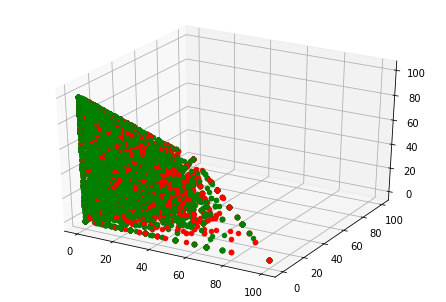

In [7]:
fig = plt.figure()
ax = Axes3D(fig)

for i in range(len(features)):
    if targets[i] == 1:
        ax.scatter(features[i,int(2)], features[i,int(3)], features[i,int(4)],c='green')
    else:
        ax.scatter(features[i,int(2)], features[i,int(3)], features[i,int(4)],c='red')
    
plt.show()